#                                           K-Means Clustering

## Problem Statement

*A key challenge for Mobile App businesses is to analyze the trend in the market to increase their sales/usage. The trend can be easily observed if the companies can group the customers based on their activity on the network.We have access to user's demographic characteristics, their app usage, geolocation, and mobile device properties. This grouping can be done by applying different criteria like App installed status, Actively using or not, phone brand compability and so on. The machine learning clustering algorithms can provide an analytical method to cluster user segment with similar interests/habits.This will help App/mobile provider better understand and interact with their subscriber.

### Import Important library and functions

In [1]:
# 'os' module provides functions for interacting with the operating system
import os

In [ ]:
#Set up our working directory
os.chdir('C:\Case Study\china-mobile-user-gemographics')
os.getcwd()

In [3]:
import numpy as np
# 'Pandas' is used for data manipulation and analysis
import pandas as pd
# 'Seaborn' is based on matplotlib; used for plotting statistical graphics
import seaborn as sns
from operator import add
from scipy import sparse, io
# 'Matplotlib' is a data visualization library for 2D and 3D plots, built on numpy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# Jupyter specific plotting display function
%matplotlib notebook
%matplotlib inline
# suppress display of warnings
import warnings
warnings.filterwarnings("ignore")

## Data Definition

*app_events.csv- Details on App is installed and used actively or not
app_labels.csv- Apps and their labels, the label_id can be used to join with label categories
events.csv- Event data has an event id, location detail (lat/long), and timestamp, when the user is using an app on his device
gender_age_train.csv- details of users age & gender
label_categories.csv- Apps' labels and their categories
phone_brand_device_model.csv- Device ids, brand, and models name. here the brands names are in Chinese, you can convert it in english using google for better understanding but we will not do it here. We will use this as profiling variable, not as clustering variable.

*First thing first- Let's start importing all input data & start exploring all data points

* Download a Kaggle data set from "https://www.kaggle.com/chinapage/china-mobile-user-gemographics"

In [4]:
# Import app_events.csv data file
App_event= pd.read_csv('app_events.csv',encoding='utf-8', dtype={'is_active': bool}, index_col='event_id')

In [5]:
#check data points
# head() to display top five rows
App_event.head()
# Note: To display more rows, example 10, use head(10)

,app_id,is_installed,is_active
event_id,,,
2,5927333115845830913,1,True
2,-5720078949152207372,1,False
2,-1633887856876571208,1,False
2,-653184325010919369,1,True
2,8693964245073640147,1,True


In [6]:
# We have multiple tables, so seems event_id, app_id can be used for data mapping/merging. but first explore these columns
App_event.shape
print('{} Total Rows'.format(App_event.shape[0]))
print('Unique Values:')
for i in App_event.columns:
    print('{}: {}'.format(i,App_event[i].nunique()))

32473067 Total Rows
Unique Values:
app_id: 19237
is_installed: 1
is_active: 2


*Is_installed has one value only that means all the apps are installed in device, so this column will be of no use in our analysis

In [7]:
# let's import all other data as well
App_label= pd.read_csv('app_labels.csv',encoding='utf-8')
events= pd.read_csv('events.csv',encoding='utf-8')
Age= pd.read_csv('gender_age_train.csv',encoding='utf-8')
label_cat= pd.read_csv('label_categories.csv',encoding='utf-8')
phone_brand= pd.read_csv('phone_brand_device_model.csv',encoding='utf-8')

In [8]:
# again do all the points which we done on the first data set to understand it better
App_label.head(3)

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406


In [9]:
print('Total Rows: {}'.format(App_label.shape[0]))
print('Unique Values:')
for i in App_label.columns:
    print('{}: {}'.format(i, App_label[i].nunique()))

Total Rows: 459943
Unique Values:
app_id: 113211
label_id: 507


In [10]:
events.head(3)

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70


In [11]:
Age.head(3)

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38


In [12]:
label_cat.head(3)

,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes


In [13]:
phone_brand.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


*Here in Phone Brand data, phone brand & model name is in chinease/different language. We can google it to convert in engish or use any translation API to learn performing language translation. If you are doing manually through google, i will suggest first get the distrubution of each brand and only convert for top 10/12 contributiong for say 90/95%. For simplicity, we will not do anything here for our use case. We will use it as given. Few important conversion is listed below-
三星 samsung

天语 Ktouch

海信 hisense

联想 lenovo

爱派尔 ipair

一加 oneplus

诺基亚 nokia

华硕 asus

夏新 panosonic

锤子 hammer

In [14]:
#check duplicates in device id & clean it
phone_devices_unique=np.unique(phone_brand['device_id'].values)
print("Number of Unique Phone Device: ",len(phone_devices_unique))
print("Total Number of Devices in Phone Data: ",phone_brand.shape[0])
print("Number of Duplicate Devices: ",phone_brand.shape[0]-len(phone_devices_unique))

Number of Unique Phone Device:  186716
Total Number of Devices in Phone Data:  187245
Number of Duplicate Devices:  529


In [15]:
#remove duplicates
phone_brand = phone_brand.drop_duplicates('device_id', keep='first')
phone_brand.shape[0]

186716

In [16]:
#Merge all data together. We can do it all together but better do one by one and learn new dimensions of data
labelled_data = (events.merge(phone_brand, how='left', on='device_id')
                            .merge(Age, how='left', on='device_id')
                            )

In [17]:
# Check new data frame look
labelled_data.head(2)

,event_id,device_id,timestamp,longitude,latitude,phone_brand,device_model,gender,age,group
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,小米,红米note,M,46.0,M39+
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,三星,Galaxy Grand Prime,NaN,NaN,NaN


In [18]:
apps_label_category=pd.merge(App_label,label_cat,on='label_id',how='left')

In [19]:
apps_label_category.head(3)

,app_id,label_id,category
0,7324884708820027918,251,Finance
1,-4494216993218550286,251,Finance
2,6058196446775239644,406,unknown


In [20]:
apps_label_category1=pd.merge(labelled_data,App_event,on='event_id',how='left')

In [21]:
apps_label_category1.head(3)

,event_id,device_id,timestamp,longitude,latitude,phone_brand,device_model,gender,age,group,app_id,is_installed,is_active
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,小米,红米note,M,46.0,M39+,NaN,NaN,NaN
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,三星,Galaxy Grand Prime,NaN,NaN,NaN,5.927333e+18,1.0,True
2,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,三星,Galaxy Grand Prime,NaN,NaN,NaN,-5.720079e+18,1.0,False


In [22]:
# let's analyze timestamp data
event_time=apps_label_category1['timestamp'].values
print("Event Start: ",np.min(event_time))
print("Event End: ",np.max(event_time))

Event Start:  2016-04-30 23:52:24
Event End:  2016-05-08 00:00:08


*The Events Data provided is for a period of 7 Days Starting from 30th April 2016 mid-night to starting of 8th May 2016

In [23]:
# let's drop timestamp and is_installed from our input data
Data_notimestamp = apps_label_category1.drop(['timestamp','is_installed'], 1)
Data_notimestamp.shape

(34237921, 11)

In [ ]:
# We ave too many rows in our data, so lets drop all naull values

In [24]:
Data_notimestamp_NoNA=Data_notimestamp.dropna()
Data_notimestamp_NoNA.shape

(12237197, 11)

*EDA/Exploratory Data Analysis

*Data preparation is the process of cleaning and transforming raw data before building the models
You should always explore all the data points and try building your initial hypothesis to see if that factor/variable can help you in solving your main problem statement/your goal

Here we analyze the data with the following steps:
1. Check dimensions of the dataframe in terms of rows and columns and study few of the variables
2. Check the data type. Refer data definition to validate the data type 
3. If the data type is not as per the business definition, change the data type as per requirement 
4. Check the distribution of variables
5. Study summary statistics
6. Check for missing values

Note: This is an art to explore the data better. Above points are only indicative as minimum requred steps. You can add to this list

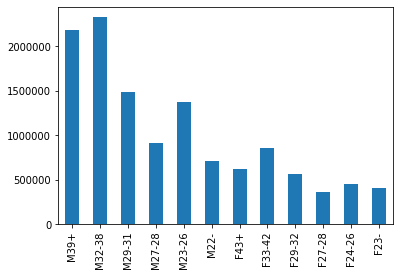

In [25]:
Data_notimestamp_NoNA.group.value_counts().sort_index(ascending=False).plot(kind='bar')

* Male gender age group is more than Female gender age group

* Lets explore proportion of male & female in data set

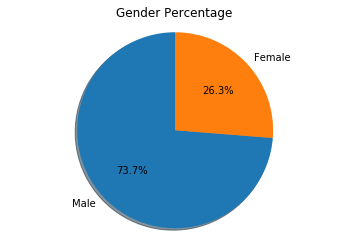

In [26]:
gender_dict = Data_notimestamp_NoNA['gender'].value_counts()
gender_labels=['Male','Female']
male_percentage=(gender_dict['M']*100)//Data_notimestamp_NoNA.shape[0]
female_percentage=(gender_dict['F']*100)//Data_notimestamp_NoNA.shape[0]
sizes=[male_percentage,female_percentage]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=gender_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Gender Percentage')
plt.show()

*Gender representATION Is not Balanced. 2/3rd are Males

* Lets check there age distribution

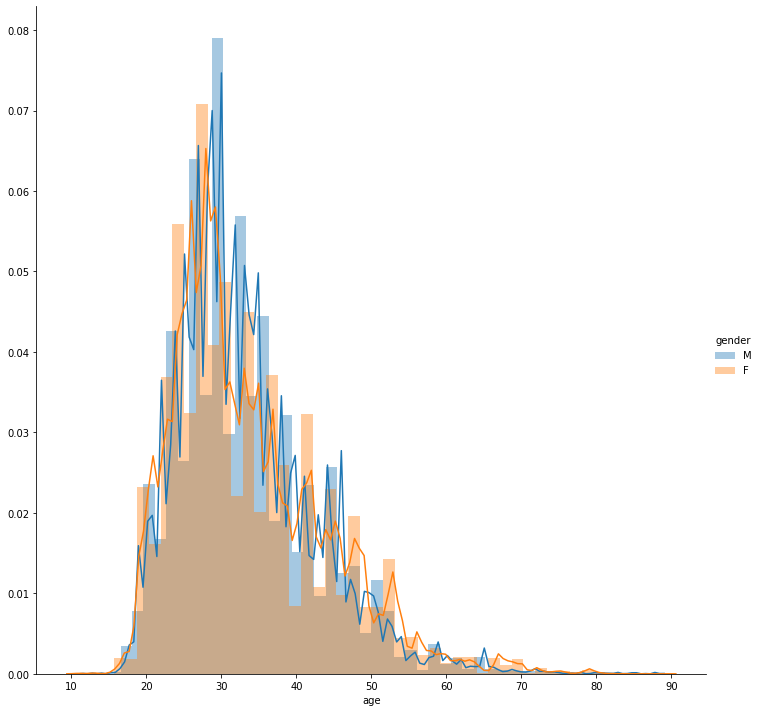

In [27]:
sns.FacetGrid(Data_notimestamp_NoNA, hue="gender", size=10).map(sns.distplot, "age").add_legend();
plt.show()

* Mostely overlap in the Number of Male and Female in age group below 46/47 but number of female are slightly more than Male in the age group above 46

In [28]:
#let's create a random sample of 5% records for our clustering learning example
data_touse= Data_notimestamp_NoNA.sample(frac=0.05,random_state=1111)
data_touse.shape

(611860, 11)

In [29]:
#still we have more than 6 lakhs data point to work. Good to go....
data_touse.describe()

,event_id,device_id,longitude,latitude,age,app_id
count,6.118600e+05,6.118600e+05,611860.000000,611860.000000,611860.000000,6.118600e+05
mean,1.625862e+06,1.028504e+17,45.064401,12.407969,33.375504,1.200933e+18
std,9.397535e+05,5.291784e+18,56.258613,15.844912,9.412878,5.364052e+18
min,6.000000e+00,-9.222957e+18,-180.000000,-33.800000,11.000000,-9.220899e+18
25%,8.118670e+05,-4.364912e+18,0.000000,0.000000,27.000000,-3.425831e+18
50%,1.626136e+06,9.353817e+16,0.000000,0.000000,31.000000,1.497693e+18
75%,2.442641e+06,4.674060e+18,113.850000,30.110000,39.000000,6.179144e+18
max,3.252948e+06,9.220915e+18,151.180000,53.640000,89.000000,9.222488e+18


* In our dataset, we have both numerical and categorical variables. We check for summary statistics of all the variables

1. For numerical variables, use .describe()
2. For categorical variables, use .describe(include=object) 

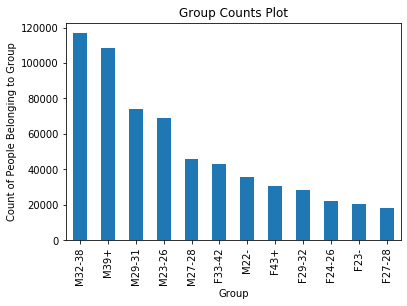

In [30]:
#see distribution of gender & age(Group) column again
plt.title('Group Counts Plot')
plt.xlabel('Group')
plt.ylabel('Count of People Belonging to Group')
data_touse['group'].value_counts().plot.bar()
plt.show()

*seems ratio is maintained after random sampling. Good to go...

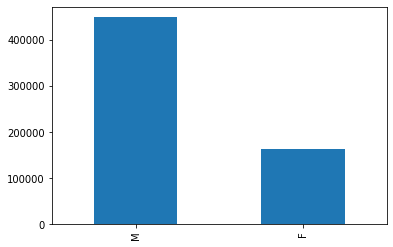

In [31]:
data_touse.gender.value_counts().plot(kind='bar')
#Expected as per original proportion. Good to go...

In [32]:
data_touse.tail(3)

,event_id,device_id,longitude,latitude,phone_brand,device_model,gender,age,group,app_id,is_active
17858740,1697198,9125896648976328820,120.20,30.21,华为,荣耀6,F,25.0,F24-26,6.602286e+18,False
5629730,536095,8265653199960723664,118.72,33.95,vivo,X5SL,F,32.0,F29-32,8.693964e+18,True
10464214,996108,2343433997974187290,0.00,0.00,vivo,Y27,F,28.0,F27-28,6.666574e+18,False


In [33]:
#lets convert the category data as numeric encoder
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
data_touse['phone_brand_Cat'] = labelencoder.fit_transform(data_touse['phone_brand'])
data_touse['device_model_Cat'] = labelencoder.fit_transform(data_touse['device_model'])
data_touse['app_id_Cat'] = labelencoder.fit_transform(data_touse['app_id'])
data_touse = pd.get_dummies(data_touse, columns=["gender"], prefix=["Type_is"] )
data_touse = pd.get_dummies(data_touse, columns=["is_active"], prefix=["Active"] )
data_touse.head(2)

,event_id,device_id,longitude,latitude,phone_brand,device_model,age,group,app_id,phone_brand_Cat,device_model_Cat,app_id_Cat,Type_is_F,Type_is_M,Active_False,Active_True
32857701,3114209,3517190067519579513,0.00,0.0,华为,荣耀7,43.0,F43+,-7.164737e+18,21,841,892,1,0,1,0
22448040,2133414,8424302192542364410,115.98,39.7,小米,MI 3,19.0,F23-,1.665047e+18,33,386,5287,1,0,0,1


In [34]:
#Let's drop original identity data as that will not help in our analysis
data_cluster= data_touse.drop(['group','phone_brand','device_model','app_id','event_id','device_id'],axis=1)

In [35]:
data_cluster.head(3)

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,app_id_Cat,Type_is_F,Type_is_M,Active_False,Active_True
32857701,0.00,0.0,43.0,21,841,892,1,0,1,0
22448040,115.98,39.7,19.0,33,386,5287,1,0,0,1
15985325,1.00,1.0,39.0,13,377,8700,0,1,0,1


*Centroid-based clustering algorithms cluster the data into non-hierarchical clusters. Such algorithms are efficient but sensitive to initial conditions and outliers. K-means is the most widely-used centroid-based clustering algorithm

In [36]:
from sklearn.cluster import KMeans
# Using the elbow method to find the optimal number of clusters
wcss =[]
for i in range (1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter =300, n_init = 10, random_state = 0)
    kmeans.fit(data_cluster)
    wcss.append(kmeans.inertia_)

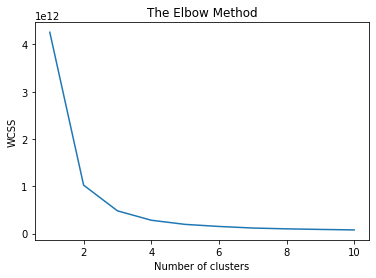

In [37]:
# Plot the graph to visualize the optimal number of cluster through the Elbow Method
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

*Feature scaling is a technique to standardize the independent features present in the data in a fixed range. If feature scaling is not done, then a machine learning algorithm tends to weigh greater values, higher and consider smaller values as the lower values, regardless of the unit of the values.
The two most discuss scaling methods are normalization and standardization.
Normalization: It should be used if there are any predefined assumptions of the model. In this approach, the data is scaled to a fixed range - usually 0 to 1
Standardization: It is used when we are dealing with multiple variables together. In this technique, the features will be rescaled so that they’ll have the properties of a standard normal distribution with (mean = 0 and sd = 1)

In [38]:
#lets compare apple to apple; scale the data
# initiate and fit StandardScaler function
from sklearn.preprocessing import StandardScaler
scale = StandardScaler().fit(data_cluster)       

# scale the 'features' data
features = scale.transform(data_cluster)

In [39]:
# create a dataframe of the scaled features 
features_scaled = pd.DataFrame( features, columns= data_cluster.columns[0:10])

# head() to display top five rows
features_scaled.head()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,app_id_Cat,Type_is_F,Type_is_M,Active_False,Active_True
0,-0.801023,-0.783089,1.022483,-0.326492,1.028427,-1.545524,1.665023,-1.665023,0.801584,-0.801584
1,1.260530,1.722449,-1.527218,0.159832,-0.755538,0.129181,1.665023,-1.665023,-1.247529,1.247529
2,-0.783248,-0.719977,0.597533,-0.650708,-0.790825,1.429697,-0.600592,0.600592,-1.247529,1.247529
3,-0.801023,-0.783089,0.597533,-0.326492,-0.692805,-1.539427,-0.600592,0.600592,0.801584,-0.801584
4,-0.801023,-0.783089,1.766145,2.267237,1.161734,-1.436544,-0.600592,0.600592,0.801584,-0.801584


*We build our models using the silhouette score method. The silhouette is a method of interpretation and validation of consistency within clusters of data.
We do not know how many clusters give the most useful results. So, we create the clusters varying K, from 3 to 6 and then decide the optimum number of clusters (K) with the help of the silhouette score

In [40]:
#using silhouette score: Higher the value, better the cluster. Earlier run suggested 3
from sklearn.metrics import silhouette_score
# create a list for different values of K
n_clusters = [3, 4, 5, 6]

# use 'for' loop to build the clusters
# 'random_state' creates the sample in the same order 
# fit and predict on the scaled data
# 'silhouette_score' function computes the silhouette score for each K
for K in n_clusters:
    cluster = KMeans (n_clusters= K, random_state= 10)
    predict = cluster.fit_predict(features_scaled)
    
    score = silhouette_score(features_scaled, predict, random_state= 10)
    print ("For n_clusters = {}, silhouette score is {})".format(K, score))

For n_clusters = 3, silhouette score is 0.23924235541301997)
For n_clusters = 4, silhouette score is 0.2404290713015018)
For n_clusters = 5, silhouette score is 0.2710075788731447)
For n_clusters = 6, silhouette score is 0.30267441944174794)


* The optimum value for K is associated with the high value of the 'silhouette score'. From the above output it can be seen that, for K = 6, the silhouette score is highest. Thus, we should try to build the clusters with K = 6 but we will continue with K=3 for saving time & learning purpose

In [41]:
#run raw cluster algo
kmeans = KMeans(n_clusters=3, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
kmeans = kmeans.fit(features_scaled)
centroids = kmeans.cluster_centers_
print(centroids)

[[-8.01546307e-01 -7.80711007e-01  4.30390950e-02  1.48186134e-01
  -3.65690464e-02 -1.26401033e-02 -6.00592153e-01  6.00592153e-01
  -1.13645712e-02  1.13645712e-02]
 [-1.73608828e-01 -1.62390568e-01  3.13633608e-02 -1.33188194e-01
  -7.90264716e-02  1.93447638e-02  1.66502342e+00 -1.66502342e+00
  -1.24343453e-01  1.24343453e-01]
 [ 1.23975375e+00  1.20181429e+00 -8.53491775e-02 -8.83687002e-02
   1.17147556e-01  7.34968918e-04 -6.00592153e-01  6.00592153e-01
   1.21427730e-01 -1.21427730e-01]]


In [42]:
# add a column 'cluster' in the data giving cluster number corresponding to each observation
data_cluster['cluster'] = kmeans.labels_

# head() to display top five rows
data_cluster.head()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,app_id_Cat,Type_is_F,Type_is_M,Active_False,Active_True,cluster
32857701,0.00,0.0,43.0,21,841,892,1,0,1,0,1
22448040,115.98,39.7,19.0,33,386,5287,1,0,0,1,1
15985325,1.00,1.0,39.0,13,377,8700,0,1,0,1,0
19447132,0.00,0.0,39.0,21,402,908,0,1,1,0,0
16521766,0.00,0.0,50.0,85,875,1178,0,1,1,0,0


In [43]:
# 'return_counts = True' gives the number observation in each cluster
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2]), array([259301, 162198, 190361], dtype=int64))

In [44]:
# get summary for observations in the whole data
data_cluster.describe()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,app_id_Cat,Type_is_F,Type_is_M,Active_False,Active_True,cluster
count,611860.000000,611860.000000,611860.000000,611860.000000,611860.000000,611860.000000,611860.000000,611860.000000,611860.000000,611860.000000,611860.000000
mean,45.064401,12.407969,33.375504,29.056162,578.699882,4947.984475,0.265090,0.734910,0.608814,0.391186,0.887327
std,56.258613,15.844912,9.412878,24.674916,255.050055,2624.345238,0.441382,0.441382,0.488016,0.488016,0.849833
min,-180.000000,-33.800000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,10.000000,387.000000,2592.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,31.000000,21.000000,645.000000,5197.500000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,113.850000,30.110000,39.000000,33.000000,838.000000,7220.000000,1.000000,1.000000,1.000000,1.000000,2.000000
max,151.180000,53.640000,89.000000,86.000000,883.000000,8947.000000,1.000000,1.000000,1.000000,1.000000,2.000000


*we analyze all the cluster formed. Few steps are:

1. Check the size of your cluster 
2. Sort the variables in the cluster 
3. Compute the statistical summary for observations in the cluster
4. Check mean, sd, freq, modes, min, max, range..all basic central tendency numbers

In [45]:
# get summary for observations in the cluster
data_cluster[data_cluster.cluster==0].describe()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,app_id_Cat,Type_is_F,Type_is_M,Active_False,Active_True,cluster
count,259301.000000,259301.000000,259301.000000,259301.000000,259301.000000,259301.000000,259301.0,259301.0,259301.000000,259301.000000,259301.0
mean,-0.029446,0.037682,33.780626,32.712639,569.372953,4914.812507,0.0,1.0,0.603268,0.396732,0.0
std,2.883687,0.867787,9.548321,27.152156,257.871928,2633.366691,0.0,0.0,0.489220,0.489220,0.0
min,-180.000000,-33.800000,12.000000,0.000000,1.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0
25%,0.000000,0.000000,27.000000,10.000000,385.000000,2554.000000,0.0,1.0,0.000000,0.000000,0.0
50%,0.000000,0.000000,32.000000,21.000000,556.000000,5116.000000,0.0,1.0,1.000000,0.000000,0.0
75%,0.000000,0.000000,39.000000,33.000000,833.000000,7141.000000,0.0,1.0,1.000000,1.000000,0.0
max,151.180000,45.530000,88.000000,86.000000,883.000000,8946.000000,0.0,1.0,1.000000,1.000000,0.0


In [46]:
# I will rename the cluster name generic, but you all should give it a intutive names like frequent users, entertainment centrics etc
G_1=data_cluster[data_cluster.cluster==0]
G_1.Type_is_F.sum()

0

In [47]:
G_1.Type_is_M.sum()

259301

In [48]:
# get summary for observations in the cluster
data_cluster[data_cluster.cluster==1].describe()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,app_id_Cat,Type_is_F,Type_is_M,Active_False,Active_True,cluster
count,162198.000000,162198.000000,162198.000000,162198.000000,162198.000000,162198.000000,162198.0,162198.0,162198.000000,162198.000000,162198.0
mean,35.297417,9.834907,33.670723,25.769757,558.544193,4998.751773,1.0,0.0,0.548133,0.451867,1.0
std,53.181822,15.136976,10.187134,23.111848,253.522257,2609.662835,0.0,0.0,0.497679,0.497679,0.0
min,-122.320000,-0.370000,11.000000,1.000000,0.000000,3.000000,1.0,0.0,0.000000,0.000000,1.0
25%,0.000000,0.000000,26.000000,10.000000,375.000000,2736.250000,1.0,0.0,0.000000,0.000000,1.0
50%,0.000000,0.000000,31.000000,21.000000,489.000000,5287.000000,1.0,0.0,1.000000,0.000000,1.0
75%,110.920000,25.860000,40.000000,33.000000,833.000000,7261.000000,1.0,0.0,1.000000,1.000000,1.0
max,139.560000,53.640000,89.000000,85.000000,881.000000,8947.000000,1.0,0.0,1.000000,1.000000,1.0


In [49]:
# get summary for observations in the cluster
data_cluster[data_cluster.cluster==2].describe()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,app_id_Cat,Type_is_F,Type_is_M,Active_False,Active_True,cluster
count,190361.000000,190361.000000,190361.000000,190361.000000,190361.000000,190361.000000,190361.0,190361.0,190361.000000,190361.000000,190361.0
mean,114.811171,31.450596,32.572123,26.875673,608.578349,4949.913286,0.0,1.0,0.668073,0.331927,2.0
std,6.008327,5.831197,8.439870,21.574233,249.768484,2623.819751,0.0,0.0,0.470906,0.470906,0.0
min,6.750000,1.370000,14.000000,1.000000,1.000000,3.000000,0.0,1.0,0.000000,0.000000,2.0
25%,112.560000,27.570000,27.000000,14.000000,396.000000,2566.000000,0.0,1.0,0.000000,0.000000,2.0
50%,115.920000,31.100000,31.000000,21.000000,706.000000,5236.000000,0.0,1.0,1.000000,0.000000,2.0
75%,119.500000,35.790000,36.000000,33.000000,838.000000,7254.000000,0.0,1.0,1.000000,1.000000,2.0
max,139.430000,52.320000,88.000000,85.000000,880.000000,8945.000000,0.0,1.0,1.000000,1.000000,2.0


In [50]:
#not good, lets fit for 4 cluster
KMeans(n_clusters=4).fit(features_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

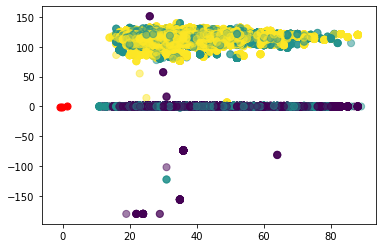

In [51]:
plt.scatter(data_cluster['age'], data_cluster['longitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

* Kmode way

#!pip install kmodes
#We have lots of categorical varibles, so let's try k-modes (Gower’s similarity coefficient)
#In K-modes algorithm, distance is measured by the number of common categorical attributes shared by the two data points

*There are lots of different cluster algorithm are available. Suggest you to read & try everything. Some popular are K Means, Agglomerative clustering, DBSCAN, Spectral clustering, Gaussian Mixtures, K-mode, Squeezer, CACTUS, ROCK, ..many more

In [52]:
from kmodes.kmodes import KModes
km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(features_scaled)

# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9297, cost: 3022174.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 16583, cost: 2905462.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 17155, cost: 2700133.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 103881, cost: 2784777.0
Run 4, iteration: 2/100, moves: 7897, cost: 2784777.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 121527, cost: 2649132.0
Run 5, iteration: 2/100, moves: 7831, cost: 2648792.0
Run 5, iteration: 3/100, moves: 25, cost: 2648792.0
Best run was number 5
[[-0.80102291 -0.7830892  -0.46484273 -0.32649222  1.01666447  1.42969703
  -0.60059215  0.60059215 -1.24752932  1.24752932]
 [-0.80102291 -0.

In [53]:
# add a column 'cluster' in the data giving cluster number corresponding to each observation
data_touse['cluster'] = km.labels_

# head() to display top five rows
data_touse.head()

,event_id,device_id,longitude,latitude,phone_brand,device_model,age,group,app_id,phone_brand_Cat,device_model_Cat,app_id_Cat,Type_is_F,Type_is_M,Active_False,Active_True,cluster
32857701,3114209,3517190067519579513,0.00,0.0,华为,荣耀7,43.0,F43+,-7.164737e+18,21,841,892,1,0,1,0,1
22448040,2133414,8424302192542364410,115.98,39.7,小米,MI 3,19.0,F23-,1.665047e+18,33,386,5287,1,0,0,1,3
15985325,1515795,-8939747905316946109,1.00,1.0,中国移动,M812C,39.0,M39+,8.693964e+18,13,377,8700,0,1,0,1,0
19447132,1846678,-8367857271888126570,0.00,0.0,华为,Mate 7,39.0,M39+,-7.127996e+18,21,402,908,0,1,1,0,2
16521766,1570007,-8161910503433321023,0.00,0.0,魅族,魅蓝metal,50.0,M39+,-6.590030e+18,85,875,1178,0,1,1,0,2


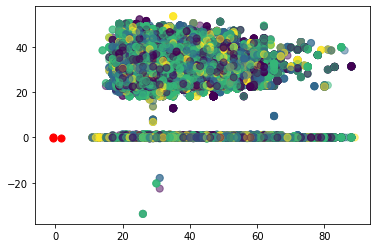

In [54]:
plt.scatter(data_touse['age'], data_touse['latitude'], c= km.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:,6], centroids[:,3], c='red', s=50)
plt.show()

In [55]:
# lets use few data columns
data_cluster_new= data_cluster.drop(['device_model_Cat','app_id_Cat','phone_brand_Cat'],axis=1)

In [56]:
#lets do dimension reduction using PCA
from sklearn.decomposition import PCA

In [57]:
# i am restricting to 2 component but you all should do proper pca to find out optimum number of component
pca_reducer = PCA(n_components=2)
reduced_data = pca_reducer.fit_transform(features_scaled)

In [58]:
reduced_data.shape

(611860, 2)

In [59]:
# Let's try again with K means
km = KMeans(n_clusters=3,random_state = 108)
cluster = km.fit(reduced_data)

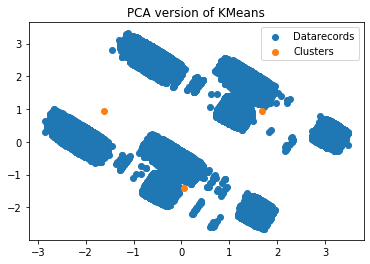

In [60]:
# Good improvement..good to go
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label='Datarecords')
plt.scatter(cluster.cluster_centers_[:, 0], cluster.cluster_centers_[:, 1], label='Clusters')
plt.title("PCA version of KMeans")
plt.legend()
plt.show()

In [61]:
#Add labels back to original data
data_touse['cluster'] = cluster.labels_

# head() to display top five rows
data_touse.head()

,event_id,device_id,longitude,latitude,phone_brand,device_model,age,group,app_id,phone_brand_Cat,device_model_Cat,app_id_Cat,Type_is_F,Type_is_M,Active_False,Active_True,cluster
32857701,3114209,3517190067519579513,0.00,0.0,华为,荣耀7,43.0,F43+,-7.164737e+18,21,841,892,1,0,1,0,2
22448040,2133414,8424302192542364410,115.98,39.7,小米,MI 3,19.0,F23-,1.665047e+18,33,386,5287,1,0,0,1,0
15985325,1515795,-8939747905316946109,1.00,1.0,中国移动,M812C,39.0,M39+,8.693964e+18,13,377,8700,0,1,0,1,0
19447132,1846678,-8367857271888126570,0.00,0.0,华为,Mate 7,39.0,M39+,-7.127996e+18,21,402,908,0,1,1,0,2
16521766,1570007,-8161910503433321023,0.00,0.0,魅族,魅蓝metal,50.0,M39+,-6.590030e+18,85,875,1178,0,1,1,0,2


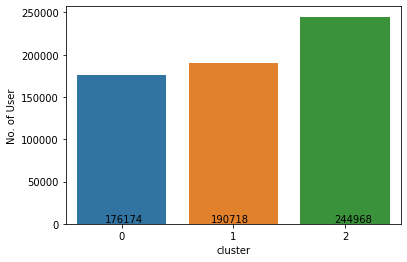

In [62]:
import seaborn as sns
sns.countplot(data= data_touse, x = 'cluster')

# give a name to the y-axis
plt.ylabel('No. of User')         

# add values in the graph
plt.text(x = -0.15, y =2000, s = np.unique(cluster.labels_, return_counts=True)[1][0])
plt.text(x = 0.8, y =2000, s = np.unique(cluster.labels_, return_counts=True)[1][1])
plt.text(x = 1.9, y =2000, s = np.unique(cluster.labels_, return_counts=True)[1][2])

plt.show()

In [63]:
G_1=data_touse[data_touse.cluster==0]
G_1.head(3)

,event_id,device_id,longitude,latitude,phone_brand,device_model,age,group,app_id,phone_brand_Cat,device_model_Cat,app_id_Cat,Type_is_F,Type_is_M,Active_False,Active_True,cluster
22448040,2133414,8424302192542364410,115.98,39.7,小米,MI 3,19.0,F23-,1.665047e+18,33,386,5287,1,0,0,1,0
15985325,1515795,-8939747905316946109,1.00,1.0,中国移动,M812C,39.0,M39+,8.693964e+18,13,377,8700,0,1,0,1,0
11514268,1094235,-3918456107891096933,0.00,0.0,华为,荣耀6 Plus,35.0,M32-38,-7.615808e+18,21,839,695,0,1,0,1,0


In [64]:
print("In cluster zero we have: {} customers".format(G_1.shape[0]))
print("Average age for customers in cluster zero: {}".format(np.array(G_1['age']).mean()))
print("Deviation of the mean for age for customers in cluster zero: {}".format(np.array(G_1['age']).std()))
print("We have {} male".format((G_1['Type_is_M'] == 1).sum()))
print("We have {} female".format((G_1['Type_is_F'] == 1).sum()))

In cluster zero we have: 176174 customers
Average age for customers in cluster zero: 33.711994959528646
Deviation of the mean for age for customers in cluster zero: 9.76336312245047
We have 102882 male
We have 73292 female


In [65]:
G_2=data_touse[data_touse.cluster==1]
print("In cluster one we have: {} customers".format(G_2.shape[0]))
print("Average age for customers in cluster one: {}".format(np.array(G_2['age']).mean()))
print("Deviation of the mean for age for customers in cluster one: {}".format(np.array(G_2['age']).std()))
print("We have {} male".format((G_2['Type_is_M'] == 1).sum()))
print("We have {} female".format((G_2['Type_is_F'] == 1).sum()))

In cluster one we have: 190718 customers
Average age for customers in cluster one: 32.5630407198062
Deviation of the mean for age for customers in cluster one: 8.441216888784515
We have 190347 male
We have 371 female


In [66]:
G_3=data_touse[data_touse.cluster==2]
print("In cluster two we have: {} customers".format(G_3.shape[0]))
print("Average age for customers in cluster two: {}".format(np.array(G_3['age']).mean()))
print("Deviation of the mean for age for customers in cluster two: {}".format(np.array(G_3['age']).std()))
print("We have {} male".format((G_3['Type_is_M'] == 1).sum()))
print("We have {} female".format((G_3['Type_is_F'] == 1).sum()))

In cluster two we have: 244968 customers
Average age for customers in cluster two: 33.76604699389308
Deviation of the mean for age for customers in cluster two: 9.824802386756309
We have 156433 male
We have 88535 female


In [67]:
G_1['phone_brand'].value_counts().head(10)
#Huawei,samsung,mi,oppo,meizu

华为      60134
三星      25123
OPPO    17896
小米      17753
魅族      13838
酷派      10622
vivo     7015
联想       6169
HTC      2699
索尼       1572
Name: phone_brand, dtype: int64

In [68]:
G_2['phone_brand'].value_counts().head(10)
#Huawei,mi,samsung,meizu,vivo

华为      75696
小米      37711
三星      15566
vivo    14781
魅族      13383
OPPO    10825
乐视       5601
酷派       3946
金立       2239
中兴       1985
Name: phone_brand, dtype: int64

In [69]:
G_3['phone_brand'].value_counts().head(10)
#Huawei,mi,samsung,oppo,meizu

华为      59083
小米      50706
三星      35746
魅族      23330
OPPO    22425
酷派      11576
vivo    10523
乐视       5986
联想       5236
金立       2624
Name: phone_brand, dtype: int64

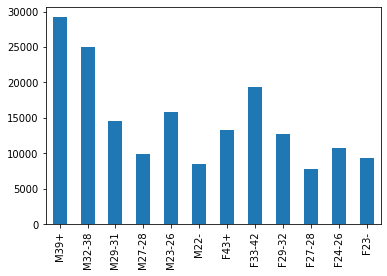

In [70]:
G_1.group.value_counts().sort_index(ascending=False).plot(kind='bar')

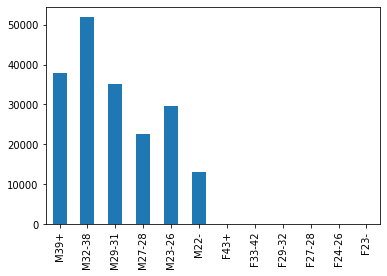

In [71]:
G_2.group.value_counts().sort_index(ascending=False).plot(kind='bar')

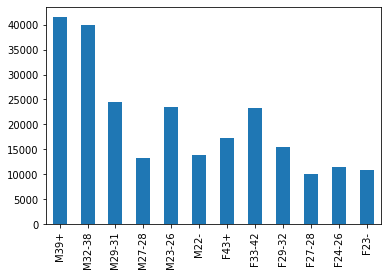

In [72]:
G_3.group.value_counts().sort_index(ascending=False).plot(kind='bar')

* Lets try KPrototypes algo, Its a combination of K-Means and K-Modes for clustering mixed attributes
This will take time to execute

In [75]:
from kmodes.kprototypes import KPrototypes

In [80]:
kproto = KPrototypes(n_clusters=5, init='Cao', verbose=2, random_state=22,n_jobs=5,max_iter=10,n_init=50)
clusters = kproto.fit_predict(data_cluster,categorical=[2,3,6,7,8,9])

Best run was number 49


In [82]:
np.unique(kproto.labels_, return_counts=True)
#Do profiling of each cluster as done above in other model iteration

(array([0, 1, 2, 3, 4], dtype=uint16),
 array([151301, 107736, 118717,  92632, 141474], dtype=int64))

In [ ]:
# try hierarchical clustering- agglomerative clustering:bottom-up approach
# Play with affinity & linkage parameter
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='average')
cluster.fit_predict(reduced_data)

In [ ]:
#This method will work in case of many continious numeric variables. So we will not run it here.
# Please refer https://scikit-learn.org/stable/modules/clustering.html for details
#mean shift
from sklearn.cluster import MeanShift
mshift = MeanShift(bandwidth=25, n_init > 1)

In [ ]:
cluster_mean = mshift.fit(features_scaled)

*Conclusion:
Based on the data from clusters we can see that there are 3 clusters with totally different spread of users. 

As we can see in the cluster 1 & 3, people around age 30 & above have the highest presence. In cluster 2, there are almost nil Females population, based on that the most exclusive apps/plans should be directly promoted to people in that group. 

Gender to target in this group is of course: Male above 30 Years. They have equally distributed in all clusters.

To get clear differentiation, we need to get more data diamensions.